In [1]:
from copy import deepcopy

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from neurasort.preprocessing import free_whisking_preprocessing_pipe

In [2]:
from sklearn.model_selection import StratifiedKFold
from neurasort.model_eval import fit_models_get_CV_scores

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree  import DecisionTreeClassifier
from sklearn.svm import SVC, NuSVC, LinearSVC
from sklearn.naive_bayes import GaussianNB

In [4]:
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from skopt.plots import plot_objective

In [5]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

In [6]:
from neurasort.sktorch import FeedForwardExample
import torch.nn as nn
import torch

In [7]:
# from scikeras.wrappers import KerasRegressor
# from neurasort.model_tf import create_model
# from keras.utils import to_categorical

# 0.0 Load raw prediction data for the free whisking setting

In [8]:
# data_ohe_scaled_constant_free_filled = pd.read_csv("data_ohe_scaled_constant_free_filled.csv")
# data_ohe_scaled_constant_free_filled

raw_predictors_free_whisking = pd.read_csv("raw_predictors_free_whisking.csv")
raw_predictors_free_whisking = raw_predictors_free_whisking.drop(["Cell_tdTomatoExpressing", "Cell_APThreshold_Slope", "Cell_Depth", "Cell_Layer"], axis=1)
raw_predictors_free_whisking

,cell_type,firing_rate,ap_threshold,ap_duration,mean_vm,std_vm,fft_low,fft_high
0,EXC,3.25,-0.028422,0.563846,-0.038375,0.005196,0.000043,0.000518
1,EXC,0.20,-0.033953,1.012500,-0.049049,0.004335,0.000053,0.000485
2,EXC,0.05,-0.039291,3.350000,-0.050940,0.005286,0.000063,0.000519
3,EXC,0.00,0.000000,0.000000,-0.047544,0.004778,0.000057,0.000557
4,EXC,0.15,-0.033361,1.733333,-0.046490,0.002881,0.000031,0.000403
...,...,...,...,...,...,...,...,...
492,SST,6.60,-0.047992,0.564015,-0.056633,0.003752,0.000066,0.000438
493,SST,6.80,-0.047427,0.578676,-0.056827,0.004175,0.000071,0.000514
494,SST,7.50,-0.047400,0.589667,-0.056011,0.004038,0.000067,0.000460
495,SST,5.50,-0.048279,0.580455,-0.056918,0.003525,0.000054,0.000430


# 0.1 Create the free whisking preprocessing pipeline

In [9]:
preprocessing_pipe = free_whisking_preprocessing_pipe()
preprocessing_pipe

Pipeline(steps=[('OHE & scaling',
                 ColumnTransformer(transformers=[('minmaxscaler',
                                                  MinMaxScaler(),
                                                  ['firing_rate', 'ap_duration',
                                                   'std_vm', 'fft_low',
                                                   'fft_high']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['ap_threshold', 'mean_vm'])],
                                   verbose_feature_names_out=False)),
                ('remove constants', VarianceThreshold()),
                ('impute cell depth', IterativeImputer(random_state=0))])

# 0.2 Calculate the class weights

In [10]:
class_weights = (1 - raw_predictors_free_whisking["cell_type"].value_counts() / raw_predictors_free_whisking["cell_type"].shape[0]).to_dict()
class_weights

{'SST': 0.6921529175050302,
 'EXC': 0.7062374245472838,
 'PV': 0.7565392354124748,
 'VIP': 0.8450704225352113}

# 0.3 Create list of models to test

In [11]:
models = [
    LogisticRegression(random_state=0, class_weight=class_weights),
    RandomForestClassifier(random_state=0, class_weight=class_weights), 
    GradientBoostingClassifier(random_state=0), 
    AdaBoostClassifier(random_state=0),
    DecisionTreeClassifier(random_state=0, class_weight=class_weights),
    SVC(random_state=0, class_weight=class_weights), 
    NuSVC(random_state=0, class_weight=class_weights), 
    LinearSVC(random_state=0, class_weight=class_weights),
    GaussianNB(),
]

# 1.0 Test all the models in the list

In [12]:
cv_scores_df = fit_models_get_CV_scores(
    models=models,
    X = raw_predictors_free_whisking.drop("cell_type", axis=1),
    y = raw_predictors_free_whisking["cell_type"],
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0),
    scoring={
        "f1":"f1_weighted", 
        # "accuracy":"accuracy",
        # "recall":"recall_weighted",
        "precision":"precision_weighted"
    },
    preprocessing_pipe=preprocessing_pipe,
)
cv_scores_df

Evaluating model: LogisticRegression
Evaluating model: RandomForestClassifier
Evaluating model: GradientBoostingClassifier
Evaluating model: AdaBoostClassifier
Evaluating model: DecisionTreeClassifier
Evaluating model: SVC
Evaluating model: NuSVC
Evaluating model: LinearSVC


/Users/wesleymonteith/miniconda3/envs/bio482/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/wesleymonteith/miniconda3/envs/bio482/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/wesleymonteith/miniconda3/envs/bio482/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/wesleymonteith/miniconda3/envs/bio482/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value

Evaluating model: GaussianNB


,model,fold,fit_time,test_f1,test_precision,train_f1,train_precision
0,LogisticRegression,0,0.055153,0.653083,0.649545,0.748912,0.747546
1,LogisticRegression,1,0.029452,0.756276,0.757329,0.742748,0.739354
2,LogisticRegression,2,0.028762,0.733389,0.763685,0.725381,0.723259
3,LogisticRegression,3,0.027457,0.701622,0.699967,0.739777,0.738702
4,LogisticRegression,4,0.032706,0.767091,0.762886,0.734042,0.735957
5,RandomForestClassifier,0,0.172616,0.775935,0.795506,1.0,1.0
6,RandomForestClassifier,1,0.191367,0.928482,0.928741,1.0,1.0
7,RandomForestClassifier,2,0.176075,0.856698,0.863048,1.0,1.0
8,RandomForestClassifier,3,0.181881,0.870224,0.873005,1.0,1.0
9,RandomForestClassifier,4,0.184202,0.918715,0.919407,1.0,1.0


# 1.1 Plot the results

In [14]:
cv_scores_df.groupby("model").mean().sort_values(by="test_f1", ascending=False)

,fold,fit_time,test_f1,test_precision,train_f1,train_precision
model,,,,,,
GradientBoostingClassifier,2.0,0.664767,0.877317,0.88286,1.0,1.0
RandomForestClassifier,2.0,0.181228,0.870011,0.875941,1.0,1.0
DecisionTreeClassifier,2.0,0.022256,0.791527,0.796773,1.0,1.0
GaussianNB,2.0,0.021145,0.772691,0.781831,0.785038,0.792208
LinearSVC,2.0,0.036832,0.769914,0.778895,0.786317,0.789554
AdaBoostClassifier,2.0,0.116801,0.751042,0.769418,0.797744,0.806115
SVC,2.0,0.025518,0.743638,0.754421,0.772305,0.783446
NuSVC,2.0,0.029445,0.741525,0.756245,0.775195,0.788327
LogisticRegression,2.0,0.034706,0.722292,0.726683,0.738172,0.736964


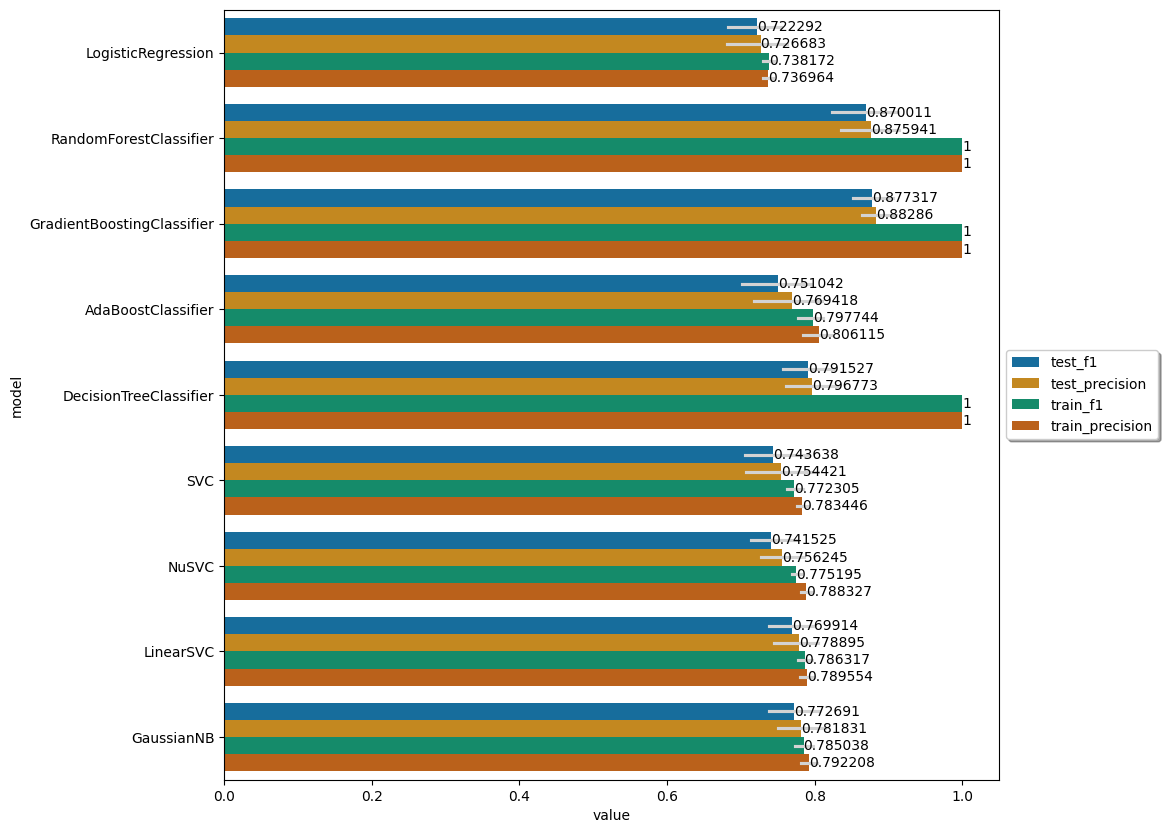

In [19]:
plt.figure(figsize=(10, 10))
ax = sns.barplot(
    data=cv_scores_df.drop("fit_time", axis=1).melt(id_vars=['model', 'fold'], var_name='measurement', value_name='value'),
    x="value",
    y="model",
    hue="measurement",
    err_kws={'color': 'lightgray'},
    palette="colorblind",
)
# ax.set_xticklabels(labels = ax.get_xticklabels() ,rotation = 45, ha="right")
for i in ax.containers:
    ax.bar_label(
        i,
    )
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fancybox=True, shadow=True)
plt.show()

# 1.2 Tune the 3 best models

## 1.2.1 GradientBoostingClassifier

(0.8814407536358173,
 OrderedDict([('clf__learning_rate', 0.1812890870724612),
              ('clf__max_depth', 8),
              ('clf__min_samples_leaf', 15),
              ('clf__n_estimators', 650)]))

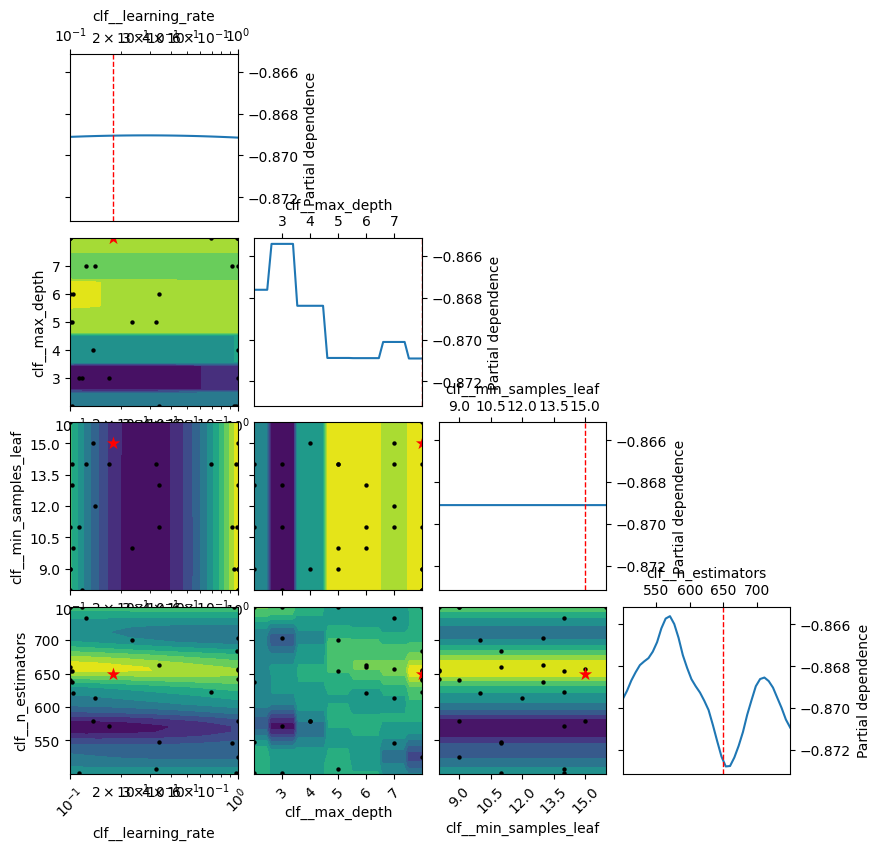

In [33]:
clf_pipe = deepcopy(preprocessing_pipe)
clf_pipe.steps.append(
    ("clf", GradientBoostingClassifier(random_state=0))
)
opt = BayesSearchCV(
    clf_pipe,
    {
        "clf__n_estimators": Integer(500, 501),
        "clf__learning_rate": Real(1e-1, 0.12163183480047841, "uniform"),
        "clf__max_depth" : Integer(7, 8),
        # "clf__min_samples_split" : Integer(8, 16),
        "clf__min_samples_leaf" : Integer(8, 16),
    },
    n_iter=2,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=0),
    random_state=0,
    scoring="f1_weighted",
)
opt.fit(
    X = raw_predictors_free_whisking.drop("cell_type", axis=1), 
    y = raw_predictors_free_whisking["cell_type"]
)
plot_objective(opt.optimizer_results_[0])
opt.best_score_, opt.best_params_

# (0.8788239918386314,
#  OrderedDict([('clf__learning_rate', 0.1737556845802626),
#               ('clf__max_depth', 3),
#               ('clf__n_estimators', 211)]))

# (0.8812119616404152,
#  OrderedDict([('clf__learning_rate', 0.12163183480047841),
#               ('clf__max_depth', 3),
#               ('clf__min_samples_leaf', 8),
#               ('clf__min_samples_split', 2),
#               ('clf__n_estimators', 500)]))

# (0.8814407536358173,
#  OrderedDict([('clf__learning_rate', 0.1812890870724612),
#               ('clf__max_depth', 8),
#               ('clf__min_samples_leaf', 15),
#               ('clf__n_estimators', 650)]))

## 1.2.2 RandomForestClassifier

In [31]:
clf_pipe = deepcopy(preprocessing_pipe)
clf_pipe.steps.append(
    ("clf", RandomForestClassifier(random_state=0, class_weight=class_weights))
)
opt = BayesSearchCV(
    clf_pipe,
    {
        "clf__n_estimators": Integer(10, 500),
        "clf__criterion": Categorical(['gini', 'entropy', 'log_loss']),
        "clf__max_depth" : Integer(2, 8),
    },
    n_iter=50,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=0),
    random_state=0,
    scoring="f1_weighted",
)
opt.fit(
    X = raw_predictors_free_whisking.drop("cell_type", axis=1), 
    y = raw_predictors_free_whisking["cell_type"]
)
plot_objective(opt.optimizer_results_[0])
plt.show()
opt.best_score_, opt.best_params_

KeyboardInterrupt: 

## 1.2.3 DecisionTreeClassifier

/Users/wesleymonteith/miniconda3/envs/bio482/lib/python3.10/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/wesleymonteith/miniconda3/envs/bio482/lib/python3.10/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/wesleymonteith/miniconda3/envs/bio482/lib/python3.10/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/wesleymonteith/miniconda3/envs/bio482/lib/python3.10/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/wesleymonteith/miniconda3/envs/bio482/lib/python3.10/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  

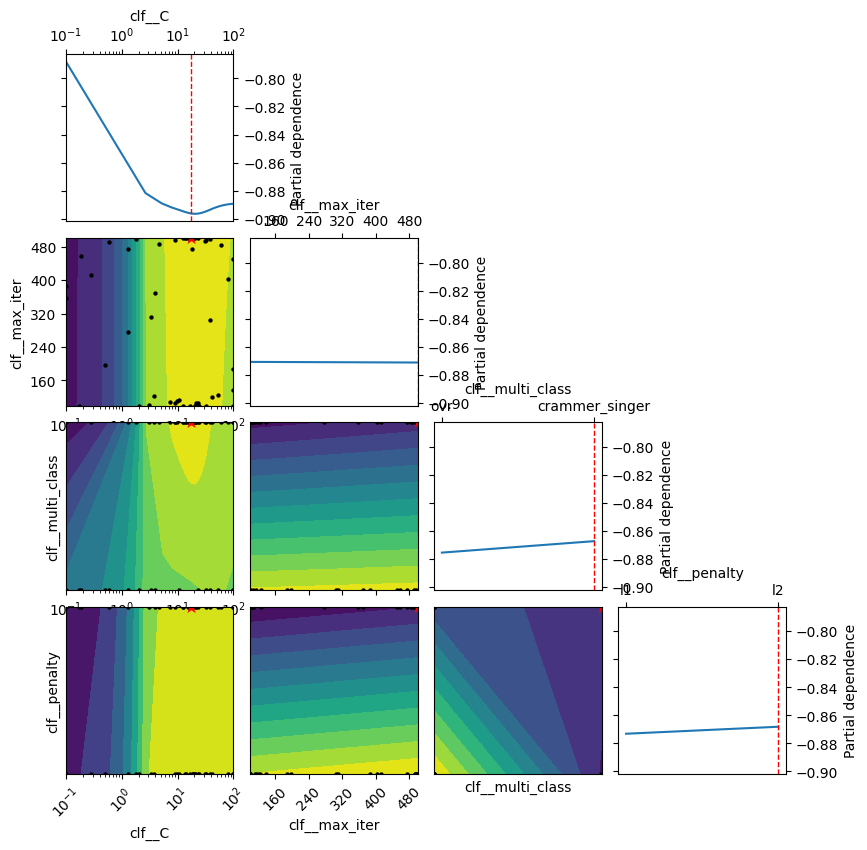

(0.9113916233380026,
 OrderedDict([('clf__C', 17.311433293929746),
              ('clf__max_iter', 500),
              ('clf__multi_class', 'crammer_singer'),
              ('clf__penalty', 'l2')]))

In [19]:
clf_pipe = deepcopy(preprocessing_pipe)
clf_pipe.steps.append(
    ("clf",  DecisionTreeClassifier(random_state=0, class_weight=class_weights))
)
opt = BayesSearchCV(
    clf_pipe,
    {
        "clf__criterion": Categorical(['gini', 'entropy', 'log_loss']),
        "clf__splitter": Categorical(['best', 'random']),
        "clf__max_depth": Integer(2, 8)
    },
    n_iter=60,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=0),
    random_state=0,
    scoring="f1_weighted",
)
opt.fit(
    X = raw_predictors_free_whisking.drop("cell_type", axis=1), 
    y = raw_predictors_free_whisking["cell_type"]
)
plot_objective(opt.optimizer_results_[0])
plt.show()
opt.best_score_, opt.best_params_

# 2.0 Test a Neural Network

In [30]:
label_encoder = LabelEncoder()
X_train, X_test, y_train, y_test = train_test_split(
    raw_predictors_free_whisking.drop("cell_type", axis=1), 
    pd.Series(label_encoder.fit_transform(raw_predictors_free_whisking["cell_type"])), 
    test_size=0.33, 
    random_state=0
)
X_train = preprocessing_pipe.fit_transform(X_train)
X_test = preprocessing_pipe.transform(X_test)

## 2.1 With Pytorch

In [31]:
from neurasort.sktorch import SkTorchEstimator
import random

In [75]:
class FeedForwardExample(SkTorchEstimator):
    def __init__(
        self,
        num_epochs: int,
        optimizer_class: torch.optim.Optimizer,
        loss_function: nn.Module,
        batch_size: int,
        lr: float,
        save_train_loss: bool = False,
        num_classes: int = 4,
        random_state: int = 0
    ) -> None:
        """Pytorch and Sklearn compatible class implementing a simple feedforward 2 layered neural net

        Args:
            num_epochs (int): Number of epochs to train.
            optimizer_class (torch.optim.Optimizer): The optimize class to use.
            loss_function (nn.Module): The class of the loss function to use.
            lr (float): The learning rate of the optimizer
            save_train_loss (bool, optional): Whether to save the train loss for every epoch during training. Defaults to False.
            num_classes (int, optional): The number of outputs desired. Defaults to 4.
        """
        super().__init__(
            num_epochs=num_epochs,
            loss_function=loss_function,
            optimizer_class=optimizer_class,
            batch_size=batch_size,
            lr=lr,
            save_train_loss=save_train_loss,
            random_state=random_state
        )
        
        random.seed(self.random_state)
        np.random.seed(self.random_state)
        torch.manual_seed(self.random_state)
        torch.use_deterministic_algorithms(True)
        
        self.layers = nn.Sequential(
            nn.LazyLinear(16),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.BatchNorm1d(16),
            nn.Linear(16, 16),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.BatchNorm1d(16),
            nn.Linear(16, num_classes),
            nn.Softmax(),
        )
        
        self.optimizer = self.optimizer_class(params=self.parameters(), lr=self.lr)

    def _reset_weights(self):
        """
        Try resetting model weights to avoid weight leakage.
        """
        for layer in self.layers.children():
            if hasattr(layer, "reset_parameters"):
                layer.reset_parameters()

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        """Pytorch compatibility. Do a forward pass in the neural net.

        Args:
            X (torch.Tensor): The data to pass forward.

        Returns:
            torch.Tensor: The output of the neural net.
        """
        return self.layers(X)

In [76]:
torch_class_weights = torch.tensor(list(class_weights.values()))
torch_class_weights

tensor([0.6922, 0.7062, 0.7565, 0.8451])

  0%|          | 0/600 [00:00<?, ?it/s]

/Users/wesleymonteith/miniconda3/envs/bio482/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
100%|██████████| 600/600 [00:12<00:00, 46.64it/s]
/Users/wesleymonteith/miniconda3/envs/bio482/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


(0.9729199818140487, 0.9390324575578032)

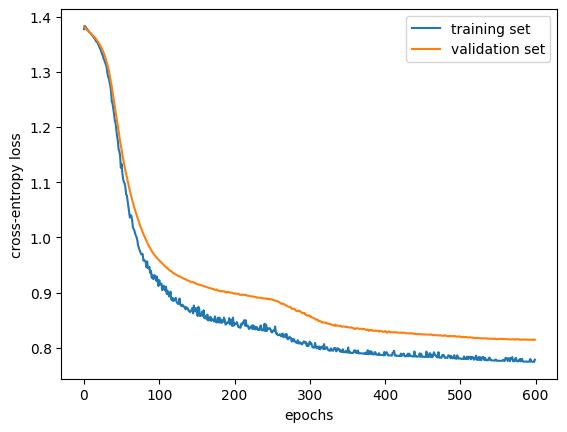

In [77]:
nn_model = FeedForwardExample(
    num_epochs=600,
    optimizer_class=torch.optim.Adamax,
    loss_function=nn.CrossEntropyLoss(weight=torch_class_weights),
    batch_size=32,
    lr=1e-3,
    save_train_loss=True,
    num_classes=4,
)
nn_model.fit(
    X=X_train,
    y=y_train,
    X_val=X_test,
    y_val=y_test,
)
plt.plot(nn_model.training_loss, label="training set")
plt.plot(nn_model.validation_loss, label="validation set")
plt.xlabel("epochs")
plt.ylabel("cross-entropy loss")
plt.legend()
f1_score(y_train, nn_model.predict(X_train), average="weighted"), f1_score(y_test, nn_model.predict(X_test), average="weighted")

In [79]:
from sklearn.model_selection import cross_val_score

pt_nn_pipe = deepcopy(preprocessing_pipe)
pt_nn_pipe.steps.append(("nn", nn_model))

cross_val_score(
    pt_nn_pipe,
    X=raw_predictors_free_whisking.drop("cell_type", axis=1),
    y=pd.Series(label_encoder.fit_transform(raw_predictors_free_whisking["cell_type"])),
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=0),
    scoring="f1_weighted",
)

  0%|          | 0/600 [00:00<?, ?it/s]/Users/wesleymonteith/miniconda3/envs/bio482/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
100%|██████████| 600/600 [00:16<00:00, 37.08it/s]
/Users/wesleymonteith/miniconda3/envs/bio482/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
  0%|          | 0/600 [00:00<?, ?it/s]/Users/wesleymonteith/miniconda3/envs/bio482/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
100%|██████████| 600/600 [00:14<00:00, 42.51it/s]
/Users/wesle

array([0.89955005, 0.92083333, 0.88774829, 0.8776025 , 0.92728274])

  0%|          | 0/315 [00:00<?, ?it/s]/Users/wesleymonteith/miniconda3/envs/bio482/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
100%|██████████| 315/315 [00:15<00:00, 19.71it/s]
/Users/wesleymonteith/miniconda3/envs/bio482/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
  0%|          | 0/315 [00:00<?, ?it/s]/Users/wesleymonteith/miniconda3/envs/bio482/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
100%|██████████| 315/315 [00:13<00:00, 22.69it/s]
/Users/wesle

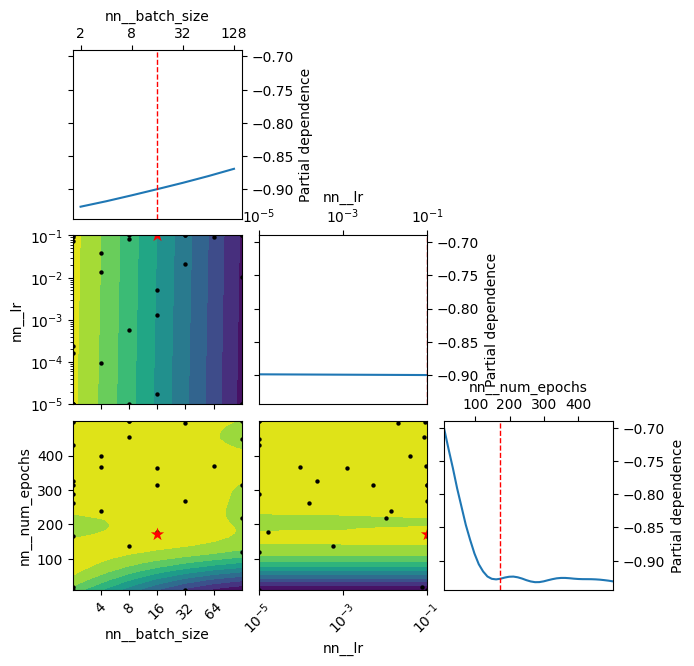

(0.9378027822029139,
 OrderedDict([('nn__batch_size', 16),
              ('nn__lr', 0.1),
              ('nn__num_epochs', 171)]))

In [33]:
opt = BayesSearchCV(
    pt_nn_pipe,
    search_spaces = {
        "nn__num_epochs": Integer(10, 500),
        "nn__batch_size": Categorical([2, 4, 8, 16, 32, 64, 128]),
        "nn__lr" : Real(1e-5, 1e-1, "log-uniform")
    },
    n_iter=30,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=0),
    random_state=0,
    scoring="f1_weighted",
)
opt.fit(
    X = raw_predictors_free_whisking.drop("cell_type", axis=1), 
    y = pd.Series(label_encoder.fit_transform(raw_predictors_free_whisking["cell_type"]))
)
plot_objective(opt.optimizer_results_[0])
plt.show()
opt.best_score_, opt.best_params_

  0%|          | 0/500 [00:00<?, ?it/s]

/Users/wesleymonteith/miniconda3/envs/bio482/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
100%|██████████| 500/500 [00:04<00:00, 105.12it/s]
/Users/wesleymonteith/miniconda3/envs/bio482/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


(0.9668221568044187, 0.8839320626521376)

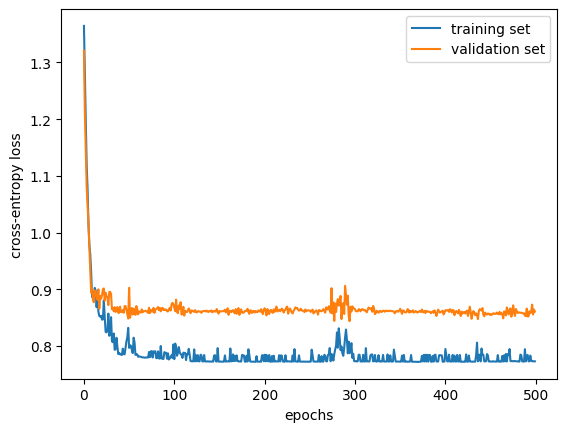

In [38]:
nn_model = FeedForwardExample(
    num_epochs=500,
    optimizer_class=torch.optim.AdamW,
    loss_function=nn.CrossEntropyLoss(weight=torch_class_weights),
    batch_size=64,
    lr=1e-2,
    save_train_loss=True,
    num_classes=4,
)
nn_model.fit(
    X=X_train,
    y=y_train,
    X_val=X_test,
    y_val=y_test,
)
plt.plot(nn_model.training_loss, label="training set")
plt.plot(nn_model.validation_loss, label="validation set")
plt.xlabel("epochs")
plt.ylabel("cross-entropy loss")
plt.legend()
f1_score(y_train, nn_model.predict(X_train), average="weighted"), f1_score(y_test, nn_model.predict(X_test), average="weighted")

## 2.2 With Keras & TF

In [12]:
y_train_one_hot = to_categorical(y_train, num_classes=4)
y_test_one_hot = to_categorical(y_test, num_classes=4)

In [27]:
clf_tf = KerasRegressor(
    build_fn=create_model, 
    verbose=1,
)

In [31]:
clf_tf.fit(
    X = X_train,
    y = y_train_one_hot,
    validation_data = [X_test, y_test_one_hot],
    epochs = 200,
)

Epoch 1/200


/Users/wesleymonteith/miniconda3/envs/bio482/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


11/11 [==============================] - 1s 24ms/step - loss: 1.4178 - f1_score: 0.2998 - val_loss: 1.4135 - val_f1_score: 0.0950
Epoch 2/200
11/11 [==============================] - 0s 5ms/step - loss: 1.4134 - f1_score: 0.0911 - val_loss: 1.4094 - val_f1_score: 0.0950
Epoch 3/200
11/11 [==============================] - 0s 5ms/step - loss: 1.4094 - f1_score: 0.0998 - val_loss: 1.4057 - val_f1_score: 0.0950
Epoch 4/200
11/11 [==============================] - 0s 5ms/step - loss: 1.4056 - f1_score: 0.1000 - val_loss: 1.4019 - val_f1_score: 0.0972
Epoch 5/200
11/11 [==============================] - 0s 5ms/step - loss: 1.4018 - f1_score: 0.0995 - val_loss: 1.3983 - val_f1_score: 0.0972
Epoch 6/200
11/11 [==============================] - 0s 5ms/step - loss: 1.3982 - f1_score: 0.0994 - val_loss: 1.3948 - val_f1_score: 0.0972
Epoch 7/200
11/11 [==============================] - 0s 5ms/step - loss: 1.3947 - f1_score: 0.0994 - val_loss: 1.3915 - val_f1_score: 0.0972
Epoch 8/200
11/11 [=====

KerasRegressor(
	model=None
	build_fn=<function create_model at 0x7fcf0a612ef0>
	warm_start=False
	random_state=None
	optimizer=rmsprop
	loss=None
	metrics=None
	batch_size=None
	validation_batch_size=None
	verbose=1
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=1
)

In [32]:
clf_tf.history_.keys()

dict_keys(['loss', 'f1_score', 'val_loss', 'val_f1_score'])

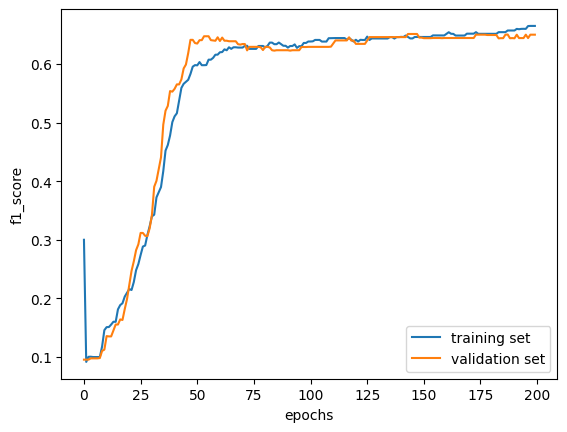

In [33]:
plt.plot(clf_tf.history_["f1_score"], label="training set")
plt.plot(clf_tf.history_["val_f1_score"], label="validation set")
plt.xlabel("epochs")
plt.ylabel("f1_score")
plt.legend()